In [1]:
import numpy as np
import pdb
import torch
import torch.nn as nn
from torch_geometric.data import Data

# from env.sys_admin import *
# from gnn_model import GraphGNNModel

import sys
sys.path.append('/home/victorialena/rlkit')

import rlkit
# from rlkit.samplers.data_collector import MdpPathCollector
from path_collector import MdpPathCollector
# from rlkit.torch.dqn.dqn import DQNTrainer
# from rlkit.torch.torch_rl_algorithm import TorchBatchRLAlgorithm

from any_replay_buffer import anyReplayBuffer
# from dqn import DQNTrainer
from policies import *

In [2]:
import numpy as np
from numpy.random import randint, choice, rand
import networkx as nx

import gym
from gym.spaces import MultiDiscrete

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils.random import erdos_renyi_graph
from torch_geometric.utils import to_dense_adj, to_networkx

from collections import namedtuple
from copy import copy, deepcopy
from typing import Optional
from enum import Enum, IntEnum

import pdb

class status(IntEnum):
    good=0
    faulty=1
    
# class load(IntEnum):
#     idle=0
#     success=1
    
class action(IntEnum): 
    noop=0 
    reboot=1
    
sysconfig = namedtuple("sysconfig", 
                       ['p_fail_base', 'p_fail_bonus', 'p_dead_base', 'p_dead_bonus',
                        'p_load', 'p_doneG', 'p_doneF',
                        'discount', 'reboot_penalty', 'job_done'], 
                       defaults=[.4,.2,.1,.5,.6,.9,.6,.9,-1., 1.])

format_input = lambda x: F.one_hot(x, num_classes=len(status)).reshape(-1,len(status)).to(torch.float32)

format_data = lambda x: (format_input(x.x), x.edge_index)

format_data_input = lambda x: format_input(x.x)

class sysAdminProbe(gym.Env):
    """
    ### Description
    
    ### Action Space
    Each community within the graph has governance of given nodes, an action notes the measure each 
    community is taking at any given time during simulation.
    
    ### State Space
    The state is defined as an arbitrary input graph where each node has an associate SEIR state. The 
    edge weights reflect transmission probabilities if either node is infectious.
    
    ### Rewards
    The reward model is defined as the sum of cost associated with each measure weighted by the size
    of the affected community.
    
    ### Starting State
    Randomly initilized stochastic Blockmodelgraph with predefined number of nodes and communities.
    
    ### Episode Termination
    The simulation terminates when no node is infectious anymore. At this point the the desease can
    no longer spread.
    
    ### Arguments
    No additional arguments are currently supported.
    """

    def __init__(self, nnodes: int, njobs: int):
        self.n_nodes = nnodes
        self.n_jobs = njobs
        self.config = sysconfig()
        self.topology = 'random'
        
        self.action_space = MultiDiscrete([len(action)] * self.n_nodes)
        self.state = None
        
    def reward(self, a):
        return torch.sum(a==action.noop) + torch.sum(a==action.reboot) * self.config.reboot_penalty
    
    def _step(self, s):
        pass
                    
    def step(self, a):
        err_msg = f"{a!r} ({type(a)}) is not a valid action."
        assert self.action_space.contains(a), err_msg
        
        a = torch.Tensor(a)
        self.n_jobs = self.n_jobs -1
        
        reward = self.reward(a)
        done = self.n_jobs == 0
        self.state.x = torch.where(torch.rand(self.n_nodes,) > self.config.p_fail_base,
                                   1,
                                   0) #self.state.x)
                
        return deepcopy(self.state), deepcopy(reward.item()), deepcopy(done), {}

    def reset(self, seed: Optional[int] = None, topology: str = 'random'):
        if not seed == None:
            super().reset(seed=seed)
        self.topology = topology
        
        if self.topology == 'random':
            edge_index = erdos_renyi_graph(self.n_nodes, 0.75, directed=False)
        elif self.topology == 'star':
            arr = torch.arange(1, self.n_nodes)
            edge_index = torch.stack([arr, torch.zeros(self.n_nodes-1, dtype=torch.int64)])
            edge_index = torch.hstack([edge_index, edge_index.flip(0)])
        elif self.topology == 'ring':
            arr = torch.arange(self.n_nodes)
            edge_index = torch.vstack([arr, arr.roll(-1,0)])
            edge_index = torch.hstack([edge_index, edge_index.flip(0)])
        else:
            err_msg = f"Unknown topology. Choose among 'ring', 'star', or 'random'."
            assert False, err_msg
            
        x = torch.zeros((self.n_nodes, 1), dtype=torch.int64) #torch.randint(high=len(status), size=(3,2))
        self.state = Data(x=x, edge_index=edge_index)
        
        return deepcopy(self.state)

    def render(self):
        pass
        g = torch_geometric.utils.to_networkx(self.state, to_undirected=True)
        colors = np.array(['green']) #, 'blue', 'red'])
        color_map = colors[self.state.x.numpy()[:, 0]]
#         labeldict = {i: 'L' if v==load.loaded else ('I' if v==load.idle else 'S')  for i, v in enumerate(self.state.x[:, 1])}
        nx.draw(g, node_color=color_map)#, labels=labeldict)
        
    def seed(self, n: int):
        super().reset(seed=seed)

In [3]:
torch.random.manual_seed(42)
np.random.seed(42)

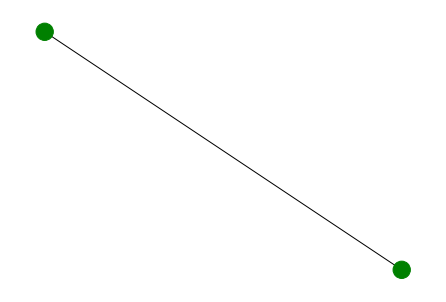

In [4]:
env = sysAdminProbe(nnodes=2, njobs=10)
x = env.reset(topology='star')
env.render()

```python
a = env.action_space.sample()
data, r, _, _ = env.step(a)
```

In [5]:
in_channels = len(status)#+len(load)
out_channels = len(action)

In [6]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [7]:
from collections import OrderedDict

from torch.nn import Linear, ReLU
import torch.nn.functional as F

class sysAdminModel(nn.Module):
    
    def __init__(self, c_in, c_out, c_hidden=64, dp_rate_linear=0.5, **kwargs):
        
        super().__init__()
        
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(in_channels, out_channels)),
#             ('relu1', nn.ReLU()),
#             ('fc2', nn.Linear(c_hidden, out_channels)),
#             ('relu2', nn.ReLU()),
#             ('fc3', nn.Linear(c_hidden, out_channels)),
            ('act', nn.Softmax(dim=1))
        ]))

        self._device = 'cpu'

    def forward(self, x, edge_index):
        return self.model(x.to(self._device))
    
    def to(self, device):
        super().to(device)
        self._device = device

In [8]:
qf = sysAdminModel(in_channels, out_channels, 16)
target_qf = sysAdminModel(in_channels, out_channels, 16)

# qf = GraphGNNModel(in_channels, 256, out_channels, use_edge_weight=False)
# target_qf = GraphGNNModel(in_channels, 256, out_channels, use_edge_weight=False)

In [9]:
from rlkit.policies.base import Policy

class sysRolloutPolicy(nn.Module, Policy):
    def __init__(self, aspace, eps=0.05):
        super().__init__()
        self.eps = eps
        self.aspace = aspace

    def get_action(self, obs):
        if rand() < self.eps:
            return self.aspace.sample(), {}
        return torch.where(obs.x[:, 0]==status.dead, action.reboot, action.noop).cpu().detach().numpy(), {}


In [10]:
qf_criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf, format_data)
# expl_policy = sysRolloutPolicy(env.action_space)
expl_policy = epsilonGreedyPolicy(qf, format_data, env.action_space, eps=0.1)

In [11]:
eval_policy.get_action(x)

(array([0, 0]), {})

```python
expl_policy = sysRolloutPolicy(env.action_space)
expl_path_collector = MdpPathCollector(env, expl_policy)
paths = expl_path_collector.collect_new_paths(1, 40, False)

for s, a, r, t in zip(paths[0]['observations'], paths[0]['actions'], 
                      paths[0]['rewards'], paths[0]['terminals']):
    print(s.x)
    print(a)
    print(r)
    print(t)
```

In [12]:
from torch.optim import Adam

In [13]:
expl_path_collector = MdpPathCollector(env, expl_policy)
eval_path_collector = MdpPathCollector(env, eval_policy)
replay_buffer = anyReplayBuffer(10000)
optimizer = Adam(qf.parameters(), lr=1E-3)

#### Reinforcement Learning

In [16]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [17]:
qf.apply(initialize_weights)
target_qf.apply(initialize_weights)

loss = []
avg_r = []
for i in range(10):
    qf.train(False)
    paths = expl_path_collector.collect_new_paths(250, 40, False)
    replay_buffer.add_paths(paths)
    
    qf.train(True)
    
    for _ in range(20):
        batch = replay_buffer.random_batch(128)
        rewards = torch.Tensor(batch['rewards']).unsqueeze(-1)
        terminals = torch.Tensor(batch['terminals'])
        actions = torch.Tensor(batch['actions'])

        obs = batch['observations']
        next_obs = batch['next_observations']
    
#         ff = lambda x: target_qf(*x)
#         out = torch.stack(list(map(ff, map(format_data, obs))), axis=0).cpu()
#         pdb.set_trace()
        X = torch.stack(list(map(format_data_input, obs)))
        out = target_qf(X, [])
        
        target_q_values = out.max(-1).values
        y_target = rewards + (1. - terminals) * 0.95 * target_q_values
        
#         ff = lambda x: qf(*x)
#         out = torch.stack(list(map(ff, map(format_data, obs))), axis=0).cpu()

        X = torch.stack(list(map(format_data_input, obs)))
        out = qf(X, [])
        
        actions_one_hot = F.one_hot(actions.to(torch.int64))
        y_pred = torch.sum(out * actions_one_hot, dim=-1)#.sum(1, keepdim=True)
        qf_loss = qf_criterion(y_pred, y_target)
        
        loss.append(qf_loss.item())
        avg_r.append(rewards.mean().item())
        
        optimizer.zero_grad()
        qf_loss.backward()
        optimizer.step()
        
    print(qf.state_dict().items())
    
    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    print("iter ", i+1, " -> loss: ", np.mean(loss[-20:]), ", rewards: ", np.mean(avg_r[-20:]))

odict_items([('model.fc1.weight', tensor([[ 0.9245,  0.2007],
        [-0.5911,  0.3316]])), ('model.fc1.bias', tensor([ 1.5073e-03, -5.6404e-05]))])
iter  1  -> loss:  2.0973972618579864 , rewards:  -0.33828125
odict_items([('model.fc1.weight', tensor([[ 0.9138,  0.2114],
        [-0.5815,  0.3219]])), ('model.fc1.bias', tensor([1.6723e-03, 8.7242e-05]))])
iter  2  -> loss:  2.1488528847694397 , rewards:  -0.32890625
odict_items([('model.fc1.weight', tensor([[ 0.9081,  0.2171],
        [-0.5606,  0.3010]])), ('model.fc1.bias', tensor([ 1.4972e-03, -4.4936e-05]))])
iter  3  -> loss:  2.156779944896698 , rewards:  -0.31640625
odict_items([('model.fc1.weight', tensor([[ 0.9025,  0.2227],
        [-0.5392,  0.2797]])), ('model.fc1.bias', tensor([ 0.0010, -0.0001]))])
iter  4  -> loss:  2.0899476230144503 , rewards:  -0.26796875
odict_items([('model.fc1.weight', tensor([[ 0.8962,  0.2289],
        [-0.5183,  0.2587]])), ('model.fc1.bias', tensor([0.0009, 0.0003]))])
iter  5  -> loss:  2.10

In [18]:
import matplotlib.pyplot as plt

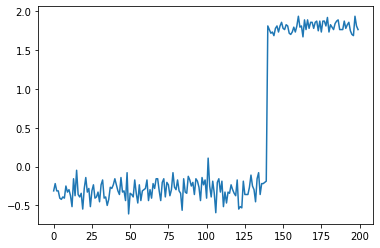

In [19]:
plt.plot(avg_r)

### Notes
1. Instead of a GCN use a normal GNN - nah
2. add self loops - default on GCNs
3. try over fitting a linear layer - done